In [1]:
import os
import numpy as np
import pydicom
import cv2
import pandas as pd
import re
from warnings import warn

In [2]:
import parsing

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Dir():
    '''base class for directories
    methods:
        parse_name -- to be defined in subclasses
    
    properties:
        content    -- a pandas.Series of filenames indexed by slice number
    '''
    def __init__(self, path):
        self.path = path
    
    def __repr__(self):
        return 'Directory: {}'.format(self.path)
        

    @property
    def content(self):
        self._content = self._list_to_series()
        self._content = self._content.map(lambda x: os.path.join(self.path, x))
        return self._content

    def __len__(self):
        return len(self.content)
    
    def _list_to_series(self,):
        'returns a pandas.Series of filenames indexed by slice number'
        if not hasattr(self, 'series_name'):
            series_name = os.path.basename(os.path.dirname(self.path))

        ser = pd.Series(os.listdir(self.path))
        ser.index = ser.map(self.parse_name).tolist()
        ser.name = series_name
        return ser

    @property
    def content(self):
        self._content = self._list_to_series()
        self._content = self._content.map(lambda x: os.path.join(self.path, x))
        return self._content

    
class DicomDir(Dir):
    @classmethod
    def parse_name(cls, fn_dcm):
        matches = re.match('([\d]+).dcm', fn_dcm)
        if matches is not None:
            slice_num = matches.groups()[0]
            slice_num = int(slice_num)
            return slice_num
        else:
            warn(f'unrecognized file:\t{fn_dcm}')
            return None

        
class ContourDir(Dir):
    @classmethod
    def parse_name(cls, fn_contour):
        matches = re.match('IM-[\d]+-([\d]+)-[a-z]contour-manual.txt', fn_contour)
        if matches is not None:
            slice_num = matches.groups()[0]
            slice_num = int(slice_num)
            return slice_num
        else:
            warn(f'unrecognized file:\t{fn_contour}')
            return None

In [5]:
def match_case_filenames(dirname_dicom, 
                         dirname_i_contour):
    filenames_dicom = DicomDir(dirname_dicom).content
    filenames_icontour = ContourDir(dirname_i_contour).content
    filenames_matched = pd.concat([filenames_dicom, filenames_icontour],
                                 axis=1, join='inner')
    if len(filenames_matched)< len(filenames_icontour):
        warn(f'some dicom slices are missing: {filenames_matched.shape[0]} matches out of {filenames_icontour.shape[0]} contours')
    
    filenames_matched.index.name = 'slice_id'
    filenames_matched.reset_index(inplace=True)
    filenames_matched.loc[:,'original_id'] = vv['original_id']
    return filenames_matched

In [6]:
def read_slice_with_annotations(slicedict):
    dcm = parsing.parse_dicom_file(slicedict['dicoms'])
    height, width = dcm['pixel_data'].shape
    
    contour = parsing.parse_contour_file(slicedict['i-contours'])
    mask = parsing.poly_to_mask(contour, width, height)

    return {'image': dcm['pixel_data'], 
            'imask': mask,
            'icontour': contour}

In [7]:
!ls final_data/

contourfiles dicoms       link.csv


In [8]:
dir_data = 'final_data'
fn_link = f'{dir_data}/link.csv'
fn_link

'final_data/link.csv'

In [9]:
metadata = pd.read_csv(fn_link)
print( f'{metadata.shape[0]} series parsed')
metadata.head()

,patient_id,original_id
0,SCD0000101,SC-HF-I-1
1,SCD0000201,SC-HF-I-2
2,SCD0000301,SC-HF-I-4
3,SCD0000401,SC-HF-I-5
4,SCD0000501,SC-HF-I-6


In [10]:
!ls {dir_data}/dicoms | head -n5

SCD0000101
SCD0000201
SCD0000301
SCD0000401
SCD0000501


In [11]:
!ls {dir_data}/contourfiles/*/i-contours | head -n5

final_data/contourfiles/SC-HF-I-1/i-contours:
IM-0001-0048-icontour-manual.txt
IM-0001-0059-icontour-manual.txt
IM-0001-0068-icontour-manual.txt
IM-0001-0079-icontour-manual.txt


In [12]:
filenames = []

for ii, vv in metadata.iterrows():
    dirname_dicom =  '{}/dicoms/{}'.format(dir_data, vv['patient_id'])
    dirname_contours =  '{}/contourfiles/{}'.format(dir_data, vv['original_id'])
    dirname_i_contour =  '{}/i-contours/'.format(dirname_contours)
#     dirname_o_contour =  '{}/o-contours/'.format(dirname_contours)
    dir_filenames = match_case_filenames(dirname_dicom, 
                         dirname_i_contour)
    filenames.append(dir_filenames)
    
filenames = pd.concat(filenames).reset_index(drop=True)
print( f'{filenames.shape[0]} files parsed')

96 files parsed


In [13]:
filenames[:5]

,slice_id,dicoms,i-contours,original_id
0,128,final_data/dicoms/SCD0000101/128.dcm,final_data/contourfiles/SC-HF-I-1/i-contours/I...,SC-HF-I-1
1,139,final_data/dicoms/SCD0000101/139.dcm,final_data/contourfiles/SC-HF-I-1/i-contours/I...,SC-HF-I-1
2,148,final_data/dicoms/SCD0000101/148.dcm,final_data/contourfiles/SC-HF-I-1/i-contours/I...,SC-HF-I-1
3,48,final_data/dicoms/SCD0000101/48.dcm,final_data/contourfiles/SC-HF-I-1/i-contours/I...,SC-HF-I-1
4,188,final_data/dicoms/SCD0000101/188.dcm,final_data/contourfiles/SC-HF-I-1/i-contours/I...,SC-HF-I-1


### sanity check: number of parsed files

In [14]:
!ls {dir_data}/contourfiles/*/i-contours/*txt | wc -l

      96


In [15]:
for kk, slicedict in filenames.iterrows():
    print(kk)
    sample = read_slice_with_annotations(slicedict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


### sanity check: contour vs mask

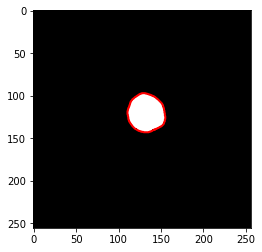

In [16]:
contour = np.asarray(sample['icontour'])

plt.imshow(sample['imask'], cmap='gray')
plt.plot(contour[:,0], contour[:,1], 'r', lw=2)

In [17]:
# def list_dir_to_series(dirname, parser, series_name=None):
#     if series_name is None:
#         series_name = os.path.basename(os.path.dirname(dirname))
    
#     ser = pd.Series(os.listdir(dirname))
#     ser.index = ser.map(parser).tolist()
#     ser.name = series_name
#     return ser
    
# def match_directories(dir_parser_tuples):
#     dir_lists = []
#     for dirname, filename_parser in dir_parser_tuples:
        
#         filenames = list_dir_to_series(dirname, filename_parser, series_name=None)
#         filenames = filenames.map(lambda x: os.path.join(dirname, x))

#         dir_lists.append(filenames)
    
#     df_names = pd.concat(dir_lists, axis=1)
#     df_names = df_names.dropna()#.reset_index()
# #     df_names['patient_id']
#     return df_names

In [18]:
# def read_slice_with_annotations_dima(slicedict):
#     dcm = pydicom.dcmread(slicedict['dicoms'])

#     contour = pd.read_csv(slicedict['i-contours'], 
#                 header=None,# names=['x','y'],
#                 delim_whitespace=True, ).values

#     return {'dcm':dcm.pixel_array, 
#             'icontour':create_binary_mask(contour, dcm)}

# def parse_contour_name(fn_contour):
#     matches = re.match('IM-[\d]+-([\d]+)-[a-z]contour-manual.txt', fn_contour)
#     if matches is not None:
#         slice_num = matches.groups()[0]
#         slice_num = int(slice_num)
#         return slice_num
#     else:
#         warn(f'unrecognized file:\t{fn_icontour}')
#         return None

In [19]:
# def create_binary_mask(contour, shape):
#     if isinstance(shape, pydicom.dataset.FileDataset):
#         shape = dcm.pixel_array.shape

#     mask = np.zeros(shape, dtype='uint8')
#     mask = cv2.fillPoly(mask, [contour.astype(np.int32)], (1))
#     return mask